In [1]:
from hamiltonian import Hamiltonian, HamiltonianH2, HamiltonianWA

In [2]:
lih = Hamiltonian('LiH', 1.5)
beh2 = Hamiltonian('BeH2', 1.3)

h2_jw = HamiltonianH2('jw')
h2_parity = HamiltonianH2('parity')
h2_bk = HamiltonianH2('bk')

water_jw = HamiltonianWA('water', 'jw')
water_parity = HamiltonianWA('water', 'parity')
water_bk = HamiltonianWA('water', 'bk')

ammonia_jw = HamiltonianWA('ammonia', 'jw')
ammonia_parity = HamiltonianWA('ammonia', 'parity')
ammonia_bk = HamiltonianWA('ammonia', 'bk')

The goal of this notebook is to render parallelise the computation of the variance.
`sparse.kron` is the expensive calculation. 

For each of the encodings `jw, parity, bk` I want to calculate the variances associated with `uniform, optimal, biased` where biased is associated with one of three norms: `1,2,infinity`.

There are therefore naturally $3*(1+1+3)$ calculations to do. And I have 15 cores at my disposal. Let's use them in parallel.


In [3]:
pr = ammonia_jw.pauli_rep
%time energy, state = pr.ground()

CPU times: user 11min 3s, sys: 2min 35s, total: 13min 38s
Wall time: 4min 49s


In [4]:
# build length-15 dictionary for molecule

# molecule = h2

encodings = {'jw': ammonia_jw, 'parity': ammonia_parity, 'bk': ammonia_bk}
algos = {}
variances = {}
for encoding, ham in encodings.items():
    pr = ham.pauli_rep
    energy, state = pr.ground()
    
    variances[encoding+'_ell_1'] = ham.pauli_rep.variance_ell_1(energy)
    
    algo = encoding+'_uniform'
    algos[algo] = [algo, pr, energy, state, pr.local_dists_uniform()]  
    
    algo = encoding+'_optimal'
    algos[algo] = [algo, pr, energy, state, pr.local_dists_optimal()]  
    
    #algo = encoding+'_1norm'
    #algos[algo]   = [algo, pr, energy, state, pr.local_dists_pnorm(1)]
    
    #algo = encoding+'_2norm'
    #algos[algo]   = [algo, pr, energy, state, pr.local_dists_pnorm(2)]
    
    #algo = encoding+'_maxnorm'
    #algos[algo]   = [algo, pr, energy, state, pr.local_dists_pnorm('infinity')]

variances

{'jw_ell_1': 3925.2892789717957,
 'parity_ell_1': 3925.289278971855,
 'bk_ell_1': 3925.2892789718826}

In [5]:
from multiprocessing import Pool
import multithread
if __name__ == '__main__':
    p = Pool(processes = 6)#15)
    output = p.map(multithread.variance, algos.values())
    
    for algo, var in output:
        variances[algo] = var

In [6]:
variances

{'jw_ell_1': 3925.2892789717957,
 'parity_ell_1': 3925.289278971855,
 'bk_ell_1': 3925.2892789718826,
 'jw_uniform': 14396.022781759535,
 'jw_optimal': 352.7397243664761,
 'parity_uniform': 27249.19500354869,
 'parity_optimal': 631.7578806702569,
 'bk_uniform': 2120.8633164846233,
 'bk_optimal': 373.9916852176471}

In [7]:
from matplotlib import pyplot as plt
import numpy as np

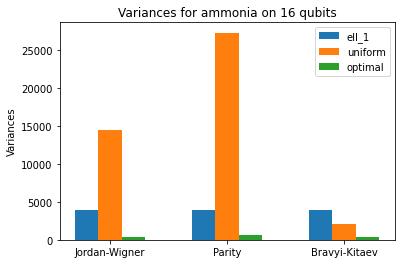

In [8]:
N = 3

ell_1_variances = [variances['{}_ell_1'.format(encoding)] for encoding in encodings]
uniform_variances = [variances['{}_uniform'.format(encoding)] for encoding in encodings]
optimal_variances = [variances['{}_optimal'.format(encoding)] for encoding in encodings]

ind = np.arange(N) 
width = 0.2       
plt.bar(ind, ell_1_variances, width, label='ell_1')
plt.bar(ind + width, uniform_variances, width, label='uniform')
plt.bar(ind + 2*width, optimal_variances, width, label='optimal')

plt.ylabel('Variances')
plt.title('Variances for ammonia on 16 qubits')

plt.xticks(ind + width, ('Jordan-Wigner', 'Parity', 'Bravyi-Kitaev'))
plt.legend(loc='best')

plt.savefig('../images/variances_ammonia_16qubits.png', dpi=300)
plt.show()

In [9]:
variances

{'jw_ell_1': 3925.2892789717957,
 'parity_ell_1': 3925.289278971855,
 'bk_ell_1': 3925.2892789718826,
 'jw_uniform': 14396.022781759535,
 'jw_optimal': 352.7397243664761,
 'parity_uniform': 27249.19500354869,
 'parity_optimal': 631.7578806702569,
 'bk_uniform': 2120.8633164846233,
 'bk_optimal': 373.9916852176471}